### Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.stats import linregress
import json
import math
import numpy as np
from scipy.optimize import curve_fit
import statistics as stat
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu
import matplotlib.lines as mlines
from sklearn.linear_model import LinearRegression
from scipy import stats

### Functions

In [2]:
#A function to calculate specificity index (tau) for a row in a pandas data frame
def compute_tau(row):
    if max(row) != 0:
        #normalize to maximal component value
        normalized_row = [value / max(row) for value in row]
        row_to_sum = [1-value for value in normalized_row]
        row_sum = sum(row_to_sum)
        n_minus_1 = len(normalized_row) - 1
        tau = row_sum / n_minus_1
        return tau
    else:
        return 'NA'

### PSI-BLAST 5 (E-value cutoff = e-10, %identity cutoff = 30%, query coverage cutoff = 1)

#### Data Loading

In [3]:
#load gene family data
with open('/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/psiblast_id-30_e-neg-10_cov-1_sequence_clusters.json') as infile:
    gene_clusters = json.load(infile)

#get list of genes in a cluster
clustered_genes = []
for cluster in gene_clusters:
    genes = gene_clusters[cluster]
    for gene in genes:
        if gene not in clustered_genes:
            clustered_genes.append(gene)

#load median data
median_expression_data = pd.read_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/count_tables/total_median_expression.csv')
median_expression_data

,genes,third-instar,fifth-instar,early-pupa,late-pupa,adult
0,lcl.KZ248545.1_cds_OWR45966.1_1,97.080300,35.084400,0.017542,0.106022,3.372090
1,lcl.KZ248545.1_cds_OWR42929.1_2,126.090500,45.856950,0.053176,0.087931,7.076445
2,lcl.KZ248545.1_cds_OWR42930.1_3,467.430000,1055.945000,117.068500,559.801500,912.306000
3,lcl.KZ248545.1_cds_OWR42931.1_4,49.189800,138.584500,1.047632,9.568825,3.719175
4,lcl.KZ248545.1_cds_OWR42932.1_5,37.760250,3.179370,3.809415,3.535095,5.591445
...,...,...,...,...,...,...
15227,lcl.KZ253939.1_cds_OWR48030.1_15228,0.060319,0.015790,0.008392,0.020840,0.178495
15228,lcl.KZ253939.1_cds_OWR48031.1_15229,40.522600,23.130550,32.661300,37.932000,16.226700
15229,lcl.KZ253939.1_cds_OWR48032.1_15230,105.923000,63.094500,153.955000,83.575550,66.509200
15230,lcl.KZ253939.1_cds_OWR48033.1_15231,0.000000,0.000000,2.164000,0.000000,0.000000


In [4]:
data = pd.read_csv("/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/gene_family_diversity_vs_expression_diversity_global_data.csv")
#drop rows with NA (indicated a Tree could not be computed for said gene cluster)
data = data.dropna()
data

,cluster,expression.pattern.diversity,centered.expression.pattern.diversity,standardized.expression.pattern.diversity,p.random,mean.tau,upper_tau_ci,lower_tau_ci,gene.cluster.phylogenetic.diversity,n.genes
0,group_0,452.705709,416.985774,20.855320,1.0,0.740595,0.798331,0.682859,21.679998,29.0
2,group_2,361.362393,188.846254,13.324558,1.0,0.633131,0.722461,0.543801,13.610648,24.0
3,group_3,2225.999123,2011.847927,33.485896,1.0,0.719054,0.772811,0.665297,34.506333,61.0
4,group_4,224.322473,185.722104,14.293780,1.0,0.737838,0.802583,0.673094,12.000454,17.0
7,group_7,606.215125,396.011512,4.396072,1.0,0.573473,0.722583,0.424363,1.798719,4.0
...,...,...,...,...,...,...,...,...,...,...
686,group_835,83.223365,68.594040,6.241678,1.0,0.574834,0.884801,0.264866,3.377283,5.0
706,group_857,959.284566,794.184049,1.325648,1.0,0.825884,0.924492,0.727277,1.432116,4.0
732,group_886,114.020761,101.582159,4.235227,1.0,0.755828,1.012006,0.499651,0.967183,4.0
744,group_898,6432.789343,4805.515333,6.587650,1.0,0.738657,0.891901,0.585413,2.769767,6.0


In [5]:
#collect and assemble data
ids = []
tau_values = []
clustered = []

for index, row in median_expression_data.iterrows():
    #add gene ids
    gene_id = row['genes']
    gene_id = gene_id.split('_')[2]
    ids.append(gene_id)
    
    #add tau
    values = list(row[['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']])
    tau = compute_tau(values)
    tau_values.append(tau)
    
    #add if gene is in a cluster
    if gene_id in clustered_genes:
        clustered.append('Clustered')
    else:
        clustered.append('Single')

tau_data = {'gene_id' : ids, 'tau' : tau_values, 'family' : clustered}
tau_dataframe = pd.DataFrame(tau_data)
tau_dataframe = tau_dataframe.loc[tau_dataframe['tau'] != 'NA']
tau_dataframe

,gene_id,tau,family
0,OWR45966.1,0.900649,Clustered
1,OWR42929.1,0.894769,Single
2,OWR42930.1,0.513089,Single
3,OWR42931.1,0.885403,Single
4,OWR42932.1,0.893305,Clustered
...,...,...,...
15227,OWR48030.1,0.85246,Clustered
15228,OWR48031.1,0.321671,Single
15229,OWR48032.1,0.481825,Single
15230,OWR48033.1,1.0,Single


In [7]:
#write to csv
tau_dataframe.to_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/tau_dataframe.csv')

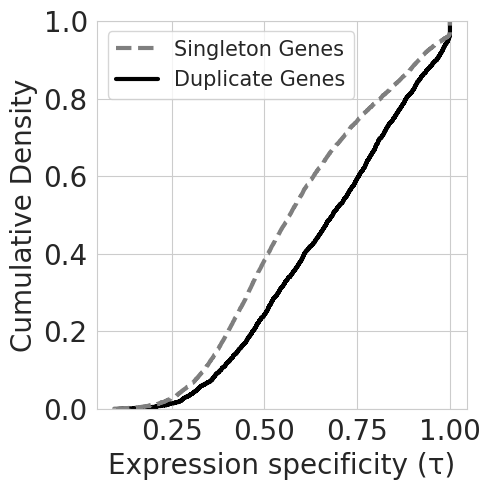

In [6]:
sns.set_style('whitegrid')
sns.set_palette('tab10')

#plot
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

#select clustered genes
culstered_df = tau_dataframe.loc[tau_dataframe['family'] == 'Clustered']
#plot
sns.ecdfplot(data=culstered_df, x="tau", ax=ax1, linewidth=3, ls='-', color='black')

#select single genes
single_df = tau_dataframe.loc[tau_dataframe['family'] == 'Single']
#plot
sns.ecdfplot(data=single_df, x="tau", ax=ax1, linewidth=3, ls='--', color='tab:gray')

#define legend
legend_lines = [mlines.Line2D([0], [0], color='tab:gray', label='Singleton Genes', linewidth=3, linestyle='--'),
                mlines.Line2D([0], [0], color='black', label='Duplicate Genes', linewidth=3)]

ax1.legend(handles=legend_lines, loc='upper left', fontsize=15)

ax1.set_xlabel('Expression specificity (\u03C4)', fontsize = 20)
ax1.set_ylabel('Cumulative Density', fontsize = 20)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/primary/expression_specificity_close.pdf')

In [8]:
#Kolmogorov–Smirnov test
clustered = list(tau_dataframe[tau_dataframe['family'] == 'Clustered']['tau'])
single = list(tau_dataframe[tau_dataframe['family'] == 'Single']['tau'])

statistic, p_value = stats.ks_2samp(clustered, single)
print(f"Test statistic = {statistic}\nP value = {p_value}")

Test statistic = 0.17499703175590992
P value = 5.42023508872627e-65


### PSI-BLAST 5 (E-value cutoff = e-5, %identity cutoff = 20%, query coverage cutoff = 0.7)

##### Data Loading

In [9]:
#load gene family data
with open('/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/psiblast_id-20_e-neg-5_cov-0.7_sequence_clusters.json') as infile:
    gene_clusters = json.load(infile)

#get list of genes in a cluster
clustered_genes = []
for cluster in gene_clusters:
    genes = gene_clusters[cluster]
    for gene in genes:
        if gene not in clustered_genes:
            clustered_genes.append(gene)

#load median data
median_expression_data = pd.read_csv('/home/gabe/Desktop/mtstp/data/intermediate_data/count_tables/total_median_expression.csv')
median_expression_data

,genes,third-instar,fifth-instar,early-pupa,late-pupa,adult
0,lcl.KZ248545.1_cds_OWR45966.1_1,97.080300,35.084400,0.017542,0.106022,3.372090
1,lcl.KZ248545.1_cds_OWR42929.1_2,126.090500,45.856950,0.053176,0.087931,7.076445
2,lcl.KZ248545.1_cds_OWR42930.1_3,467.430000,1055.945000,117.068500,559.801500,912.306000
3,lcl.KZ248545.1_cds_OWR42931.1_4,49.189800,138.584500,1.047632,9.568825,3.719175
4,lcl.KZ248545.1_cds_OWR42932.1_5,37.760250,3.179370,3.809415,3.535095,5.591445
...,...,...,...,...,...,...
15227,lcl.KZ253939.1_cds_OWR48030.1_15228,0.060319,0.015790,0.008392,0.020840,0.178495
15228,lcl.KZ253939.1_cds_OWR48031.1_15229,40.522600,23.130550,32.661300,37.932000,16.226700
15229,lcl.KZ253939.1_cds_OWR48032.1_15230,105.923000,63.094500,153.955000,83.575550,66.509200
15230,lcl.KZ253939.1_cds_OWR48033.1_15231,0.000000,0.000000,2.164000,0.000000,0.000000


In [10]:
data = pd.read_csv("/home/gabe/Desktop/mtstp/data/intermediate_data/gene_cluster_diversity_analysis/gene_family_diversity_vs_expression_diversity_global_data_distant.csv")
#drop rows with NA (indicated a Tree could not be computed for said gene cluster)
data = data.dropna()
data

,cluster,expression.pattern.diversity,centered.expression.pattern.diversity,standardized.expression.pattern.diversity,p.random,mean.tau,upper_tau_ci,lower_tau_ci,gene.cluster.phylogenetic.diversity,n.genes
1,group_1,1177.209248,1077.348995,29.775757,1.0,0.714199,0.762797,0.665600,37.594739,50.0
2,group_2,750.037179,578.494755,24.723427,1.0,0.684291,0.761182,0.607400,24.780394,36.0
3,group_3,241.867669,218.771024,5.771395,1.0,0.912716,1.055862,0.769570,3.891267,5.0
5,group_5,724.890854,472.338610,35.076300,1.0,0.583971,0.636633,0.531309,58.679838,60.0
10,group_10,428.591115,315.825372,17.355616,1.0,0.621014,0.735200,0.506828,13.969869,23.0
...,...,...,...,...,...,...,...,...,...,...
831,group_1268,3228.361390,1564.212264,3.946589,1.0,0.691223,1.385855,-0.003410,0.004462,4.0
852,group_1295,133.413955,114.085884,3.590697,1.0,0.898244,0.974811,0.821677,1.151052,4.0
857,group_1301,7.155872,3.750008,5.115644,1.0,0.601711,1.037610,0.165812,1.366246,4.0
864,group_1310,36.877276,30.701495,0.177158,1.0,0.945216,0.963990,0.926443,1.408296,4.0


In [11]:
#collect and assemble data
ids = []
tau_values = []
clustered = []

for index, row in median_expression_data.iterrows():
    #add gene ids
    gene_id = row['genes']
    gene_id = gene_id.split('_')[2]
    ids.append(gene_id)
    
    #add tau
    values = list(row[['third-instar', 'fifth-instar', 'early-pupa', 'late-pupa', 'adult']])
    tau = compute_tau(values)
    tau_values.append(tau)
    
    #add if gene is in a cluster
    if gene_id in clustered_genes:
        clustered.append('Clustered')
    else:
        clustered.append('Single')

tau_data = {'gene_id' : ids, 'tau' : tau_values, 'family' : clustered}
tau_dataframe = pd.DataFrame(tau_data)
tau_dataframe = tau_dataframe.loc[tau_dataframe['tau'] != 'NA']
tau_dataframe

,gene_id,tau,family
0,OWR45966.1,0.900649,Clustered
1,OWR42929.1,0.894769,Clustered
2,OWR42930.1,0.513089,Clustered
3,OWR42931.1,0.885403,Clustered
4,OWR42932.1,0.893305,Clustered
...,...,...,...
15227,OWR48030.1,0.85246,Clustered
15228,OWR48031.1,0.321671,Single
15229,OWR48032.1,0.481825,Single
15230,OWR48033.1,1.0,Single


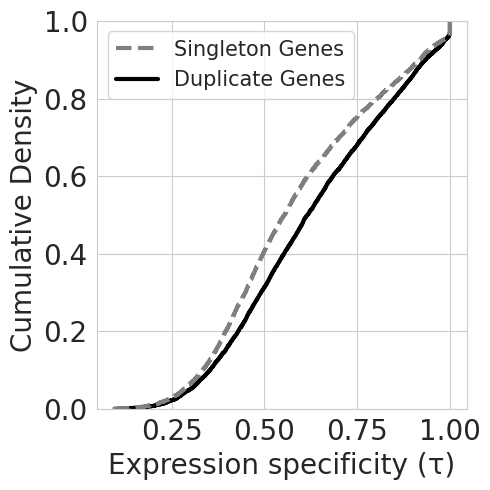

In [13]:
sns.set_style('whitegrid')
sns.set_palette('tab10')

#plot
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5))

#select clustered genes
culstered_df = tau_dataframe.loc[tau_dataframe['family'] == 'Clustered']
#plot
sns.ecdfplot(data=culstered_df, x="tau", ax=ax1, linewidth=3, ls='-', color='black')

#select single genes
single_df = tau_dataframe.loc[tau_dataframe['family'] == 'Single']
#plot
sns.ecdfplot(data=single_df, x="tau", ax=ax1, linewidth=3, ls='--', color='tab:gray')

#define legend
legend_lines = [mlines.Line2D([0], [0], color='tab:gray', label='Singleton Genes', linewidth=3, linestyle='--'),
                mlines.Line2D([0], [0], color='black', label='Duplicate Genes', linewidth=3)]

ax1.legend(handles=legend_lines, loc='upper left', fontsize=15)

ax1.set_xlabel('Expression specificity (\u03C4)', fontsize = 20)
ax1.set_ylabel('Cumulative Density', fontsize = 20)

ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

plt.tight_layout()
plt.savefig('/home/gabe/Desktop/mtstp/figures/primary/expression_specificity_distant.pdf')

In [14]:
#Kolmogorov–Smirnov test
clustered = list(tau_dataframe[tau_dataframe['family'] == 'Clustered']['tau'])
single = list(tau_dataframe[tau_dataframe['family'] == 'Single']['tau'])

statistic, p_value = stats.ks_2samp(clustered, single)
print(f"Test statistic = {statistic}\nP value = {p_value}")

Test statistic = 0.10480301132434636
P value = 3.2194566241501347e-34
